In [2]:
import pandas as pd
import json, re
import seaborn as sb
import swifter
from functools import reduce
from operator import getitem

pd.set_option('display.max_columns', None)

In [3]:
nexar_alternates = pd.read_csv("../data/puma_mpns_alternates_from_nexar.csv")
sylicon_alternates = pd.read_csv("../data/puma_mpns_alternates_from_sylicon.csv")

In [4]:
nexar_alternates_modified = nexar_alternates.copy()
nexar_alternates_modified['alternate_mpn'] = nexar_alternates['alternate_mpn'].apply(lambda x: re.sub(r'[^\w]', '', str(x).lower()))
sylicon_alternates_modified = sylicon_alternates[['original_mpn', 'alternate_mpn']].copy()
sylicon_alternates_modified['alternate_mpn'] = sylicon_alternates['alternate_mpn'].apply(lambda x: re.sub(r'[^\w]', '', str(x).lower()))
final_alternates_df = pd.concat([nexar_alternates_modified, sylicon_alternates_modified]).drop_duplicates().reset_index(drop=True)
final_alternates_df = final_alternates_df[final_alternates_df.swifter.apply(lambda x: x['original_mpn']!=x['alternate_mpn'], axis=1)]

In [5]:
with open("../data/set_of_mpns_sylicon_data_.json", 'r', encoding='utf-8') as json_file:
    sylicon_expert_raw_data = json.load(json_file)

In [6]:
collected_parts = set(map(lambda line: re.sub(r'[^\w]', '', str(line['SummaryData']['PartNumber']).lower()), sylicon_expert_raw_data))

In [7]:
df_alternates_collected = final_alternates_df[final_alternates_df.swifter.apply(lambda x: x['original_mpn'] in collected_parts and x['alternate_mpn'] in collected_parts, axis=1)]

Pandas Apply:   0%|          | 0/2180720 [00:00<?, ?it/s]

In [48]:
df_alternates_collected

,original_mpn,alternate_mpn
344,erj1trqf1r8u,crcw25121r80fneg
621,mcr18ezpf1002,rc1206fr0710kl
623,mcr18ezpf1002,ac1206fr0710kl
624,mcr18ezpf1002,rk73h2bttd1002f
782,erjs1tf1001u,crcw25121k00fkeg
...,...,...
2180834,vj0402q0r5bxapw1bc,gcm1555c1hr50ba16w
2180836,vj0402q0r5bxapw1bc,gcm1555c1hr50ba16d
2181802,crcw12061005f,af1206fr0710ml
2181809,crcw12061005f,nrcas12f1005trqyf


## 1. Generic structure of a component data

In [8]:
def get_nested_item(data, keys):
    """
    This is to get the value of a key path in a dictionnary
    """
    return reduce(getitem, keys, data)

def safe_get_nested_item(data, keys):
    try:
        return get_nested_item(data, keys)
    except:
        return None

def block_structure(block: dict):
    """
    This is to get the generic data structure of a component
    """
    tmp = {}
    for key in block:
        if type(block[key])!=dict:
            tmp[key] = type(block[key])
        else:
            tmp[key] = block_structure(block[key])
    return tmp

def merge(a, b):
    """
    This is to merge two dictionnaries deeply (recursively), taking all the keys in the two dictionnaries
    """
    for key in b:
        if key in a:
            if isinstance(a[key], dict) and isinstance(b[key], dict):
                merge(a[key], b[key])
            else:
                a[key] = b[key]
        else:
            a[key] = b[key]
    return a

def get_features_path(block_structure: dict):
    """
    block_strucure: A dictionnary that describes a data structure
    
    Result : A dictionnary, where each key of the is the path to a leaf in the tree represented by block_structure
    """
    features_path = {}
    for key in block_structure:
        if type(block_structure[key])!=dict:
            features_path[key] = block_structure[key]
        else:
            tmp = get_features_path(block_structure[key])
            for child_key in tmp:
                features_path["{}|{}".format(key, child_key)] = tmp[child_key]
    return features_path

In [9]:
component_data_structure = {}
for component in sylicon_expert_raw_data:
    component_data_structure = merge(component_data_structure, block_structure(component))
features_path = get_features_path(component_data_structure)

## 2. Extract features with enough data

In [86]:
features_stats = {}
for component in sylicon_expert_raw_data:
    for feature in features_path:
        try:
            val = get_nested_item(component, feature.split("|"))
            features_stats[feature] = features_stats.get(feature, 0) + 1
        except:
            pass
usable_features = {x: features_path[x] for x in filter(lambda x: features_stats[x]/len(sylicon_expert_raw_data)>0.8, features_stats.keys())}

### 2.1. For non-list features

In [96]:
tmp = pd.DataFrame.from_dict({x: features_stats[x] for x in filter(lambda x: usable_features[x]!=list, usable_features.keys())}, orient='index')
tmp.reset_index(inplace=True)
tmp.columns = ['feature', 'coverage']
tmp['coverage'] = tmp['coverage']*100/len(sylicon_expert_raw_data)
tmp

,feature,coverage
0,RequestedComID,100.000000
1,DesignResourcesData|PinOutData|PinOutDataSource,99.939262
2,AverageInventory,100.000000
3,FullCounterfeitData|CounterfeitOverallRisk,99.835141
4,FullCounterfeitData|PartNumCounterfeitReportsC...,99.835141
...,...,...
120,RiskData|SEGrade,99.876046
121,RiskData|LastUpdateDate,99.876046
122,RiskData|YeolComment,99.876046
123,ProductImage|ProductImageSmall,99.876046


In [97]:
final_features_coverage_df = tmp.copy()

In [ ]:
sb.set(rc={"figure.figsize": (7, 60)})
sb.barplot(data=tmp, y='feature', x='coverage', color='royalblue')

### 2.2. For list features

In [83]:
# Here are the list features that have values for at least 80% of the dataset
# We are going the study the feature in that lists next
# Except AllPackageData|Feature because it is a copy of PackageData|Feature
# Except History|Lifecycle because we are not going to consider this for the moment

list(filter(lambda x: usable_features[x]==list, usable_features.keys()))

['AllPackageData|Feature',
 'PackageData|Feature',
 'ParametricData|Features',
 'History|Lifecycle']

#### a) PackageData|Feature

In [98]:
package_data_features_stats = {}
for component in sylicon_expert_raw_data:
    tmp_feature_data = safe_get_nested_item(component, 'PackageData|Feature'.split('|'))
    if tmp_feature_data!=None:
        if type(tmp_feature_data) == list:
            for feature_dict in tmp_feature_data:
                package_data_features_stats["{}>{}".format('PackageData|Feature', feature_dict['FeatureName'])] = package_data_features_stats.get("{}>{}".format('PackageData|Feature', feature_dict['FeatureName']), 0) + 1
        else:
            package_data_features_stats["{}|{}".format('PackageData|Feature', tmp_feature_data['FeatureName'])] = package_data_features_stats.get("{}|{}".format('PackageData|Feature', tmp_feature_data['FeatureName']), 0) + 1

tmp = pd.DataFrame.from_dict(package_data_features_stats, orient='index')
tmp.reset_index(inplace=True)
tmp.columns = ['feature', 'coverage']
tmp['coverage'] = tmp['coverage']*100/len(sylicon_expert_raw_data)
tmp = tmp[tmp['coverage']>=60]
tmp

,feature,coverage
2,PackageData|Feature>Mounting,98.289433
18,PackageData|Feature>Number of Terminals,67.743415
19,PackageData|Feature>Package/Case,62.563372
20,PackageData|Feature>Product Depth,69.685776
21,PackageData|Feature>Product Diameter,68.554075
22,PackageData|Feature>Product Height,69.677099
23,PackageData|Feature>Product Length,69.688255
24,PackageData|Feature>Product Weight,68.562752
26,PackageData|Feature>Terminal Pitch,66.562132
27,PackageData|Feature>Termination Style,66.264642


In [99]:
final_features_coverage_df = pd.concat([final_features_coverage_df, tmp])

<AxesSubplot: xlabel='coverage', ylabel='feature'>

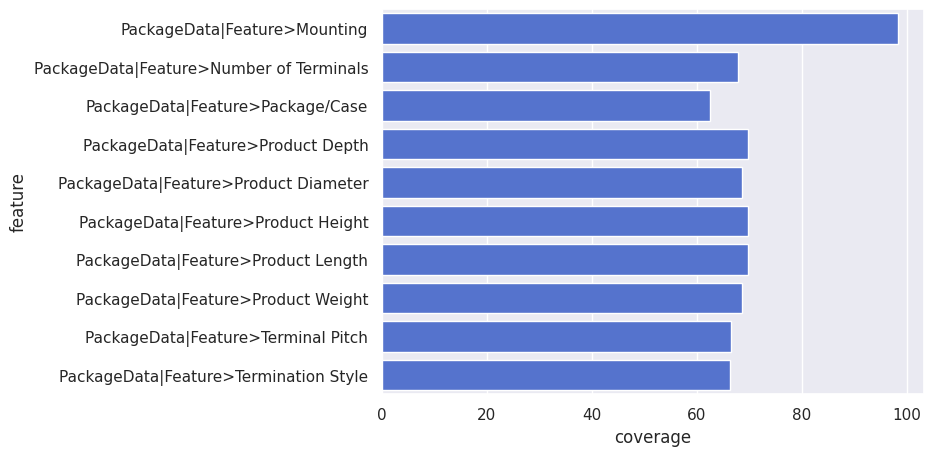

In [93]:
sb.set(rc={"figure.figsize": (7, 5)})
sb.barplot(data=tmp, y='feature', x='coverage', color='royalblue')

#### b) ParametricData|Features

In [100]:
parametric_data_features_stats = {}
for component in sylicon_expert_raw_data:
    tmp_feature_data = safe_get_nested_item(component, 'ParametricData|Features'.split('|'))
    if tmp_feature_data!=None:
        if type(tmp_feature_data) == list:
            for feature_dict in tmp_feature_data:
                parametric_data_features_stats["{}>{}".format('ParametricData|Features', feature_dict['FeatureName'])] = parametric_data_features_stats.get("{}>{}".format('ParametricData|Features', feature_dict['FeatureName']), 0) + 1
        else:
            parametric_data_features_stats["{}|{}".format('ParametricData|Features', tmp_feature_data['FeatureName'])] = parametric_data_features_stats.get("{}|{}".format('ParametricData|Features', tmp_feature_data['FeatureName']), 0) + 1

tmp = pd.DataFrame.from_dict(parametric_data_features_stats, orient='index')
tmp.reset_index(inplace=True)
tmp.columns = ['feature', 'coverage']
tmp['coverage'] = tmp['coverage']*100/len(sylicon_expert_raw_data)
tmp = tmp[tmp['coverage']>=60]
tmp

,feature,coverage
11,ParametricData|Features>Life Cycle,97.431670
18,ParametricData|Features>Maximum Operating Temp...,96.115277
21,ParametricData|Features>Minimum Operating Temp...,95.997521
27,ParametricData|Features>Packaging,83.924388
33,ParametricData|Features>ROHS,97.682058
39,ParametricData|Features>Temperature Grade,67.593430
51,ParametricData|Features>Mounting,69.818407
53,ParametricData|Features>Number of Terminals,67.980167
54,ParametricData|Features>Operating Temperature,68.769755
59,ParametricData|Features>Product Height,63.096374


In [101]:
final_features_coverage_df = pd.concat([final_features_coverage_df, tmp])

<AxesSubplot: xlabel='coverage', ylabel='feature'>

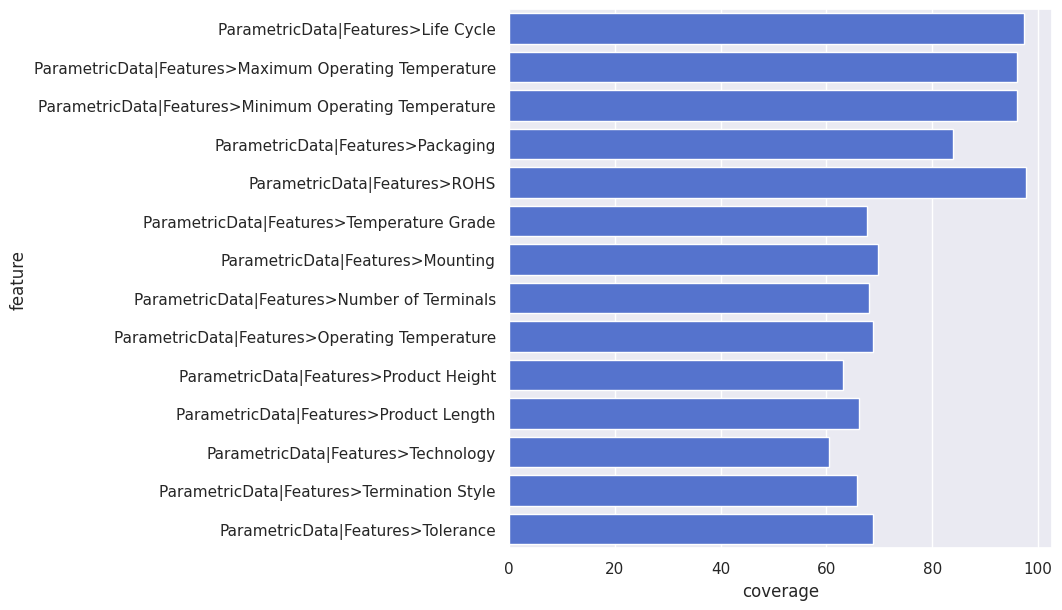

In [95]:
sb.set(rc={"figure.figsize": (7, 7)})
sb.barplot(data=tmp, y='feature', x='coverage', color='royalblue')

In [ ]:
sb.set(rc={"figure.figsize": (7, 30)})
sb.barplot(data=final_features_coverage_df, y='feature', x='coverage', color='royalblue')

## 3. Final DataFrame construction

In [107]:
final_features_coverage_df

,feature,coverage
0,RequestedComID,100.000000
1,DesignResourcesData|PinOutData|PinOutDataSource,99.939262
2,AverageInventory,100.000000
3,FullCounterfeitData|CounterfeitOverallRisk,99.835141
4,FullCounterfeitData|PartNumCounterfeitReportsC...,99.835141
...,...,...
59,ParametricData|Features>Product Height,63.096374
60,ParametricData|Features>Product Length,66.130772
63,ParametricData|Features>Technology,60.582584
64,ParametricData|Features>Termination Style,65.789898
